### Hypothesis: Can we infer the malignancy of the lesion by patient information age,sex  and location of lesion.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [25]:
# load csv
data = pd.read_csv('../data/processed/Metadata_processed.csv')

In [26]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,not_skin_cancer


In [27]:
# define X and y
y = data['dx_binary']
X = data.drop(['dx_binary'], axis=1)
X = X.drop(["lesion_id"], axis=1)
X = X.drop(["image_id"], axis=1)
X = X.drop(["dataset"], axis=1)
X = X.drop(['dx'], axis=1)
X = X.drop(['dx_type'], axis=1)

In [28]:
X.head()

,age,sex,localization
0,80.0,male,scalp
1,80.0,male,scalp
2,80.0,male,scalp
3,80.0,male,scalp
4,75.0,male,ear


In [29]:
y.head()

0    not_skin_cancer
1    not_skin_cancer
2    not_skin_cancer
3    not_skin_cancer
4    not_skin_cancer
Name: dx_binary, dtype: object

In [30]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [31]:
# one hot encode categorical variables
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False, categories='auto')

X_train = pd.DataFrame(encoder.fit_transform(X_train))
X_test = pd.DataFrame(encoder.transform(X_test))

In [32]:
#get feature names

feature_names = list(encoder.get_feature_names_out())


In [33]:
# encode labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# view labels
y_train[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
# train xgboost model
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4)

# fit model on training data
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=4,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
# cross validation with XGBoost

from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X_train, y_train, cv=5, scoring='accuracy', return_train_score=True)


In [36]:
# get the best model
best_model = model

# get the best model parameters
best_params = model.get_params()

# get the best model score on the test set
best_score = cv_results['test_score'].mean()

# get the best model score on the train set
best_score_train = cv_results['train_score'].mean()

In [37]:
# make predictions for test data
y_pred = model.predict(X_test)

In [38]:
model.get_booster().feature_names = feature_names

Accuracy: 81.43%


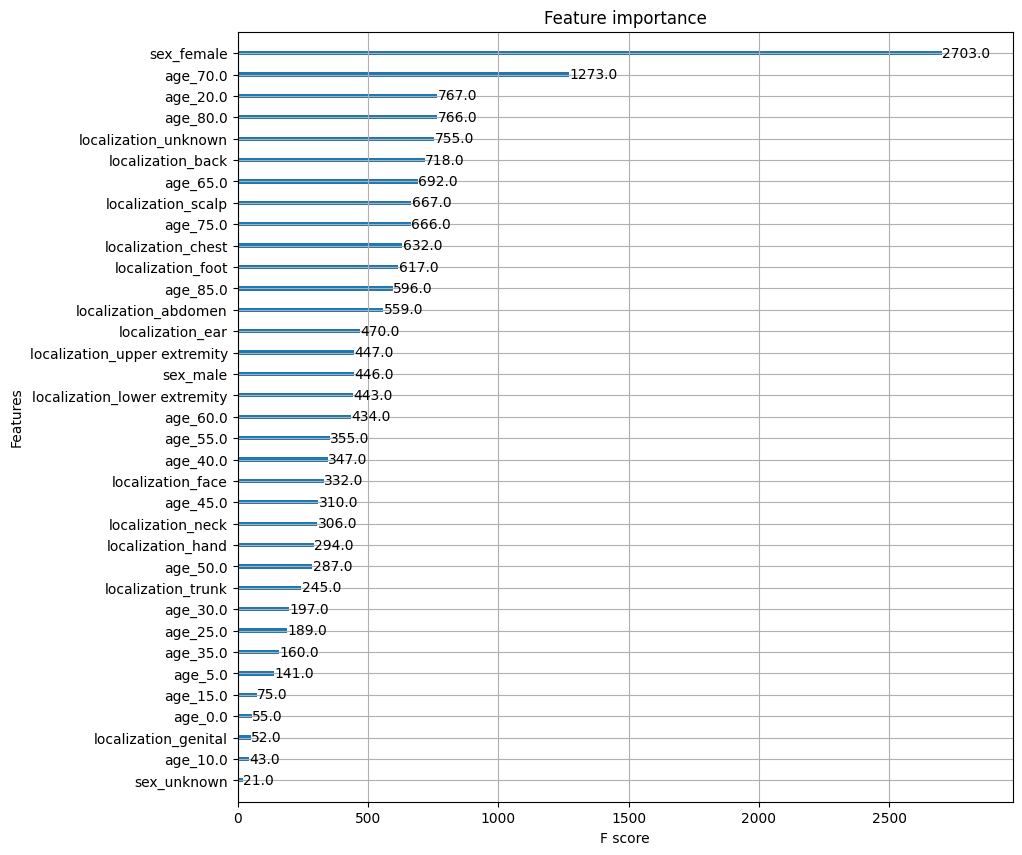

In [44]:
# evaluate predictions
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# plot feature importance
from xgboost import plot_importance

plot_importance(model)

# increase figure size
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()


In [40]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1925   79]
 [ 386  114]]


0.5942894211576847


Text(0.5, 1.0, 'ROC Curve Metadata-XGBoost')

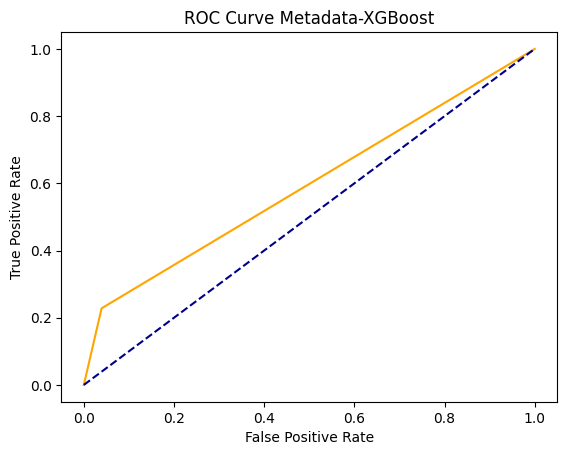

In [42]:
# roc auc score
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, y_pred))

# roc curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Metadata-XGBoost')